In [204]:
from lifelines.datasets import load_waltons, load_dd


import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

dd = load_dd()
df = load_waltons()
df.head()
dd.head()

,T,E,group
0,6.0,1,miR-137
1,13.0,1,miR-137
2,13.0,1,miR-137
3,13.0,1,miR-137
4,19.0,1,miR-137


In [49]:
df[df.E==0]

,T,E,group
39,61.0,0,control
41,61.0,0,control
54,69.0,0,control
71,68.0,0,control
89,7.0,0,control
144,45.0,0,control
152,60.0,0,control


# KaplanMeierFitter

In [50]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(df[['T']], event_observed=df[['E']])

<lifelines.KaplanMeierFitter: fitted with 163 observations, 7 censored>

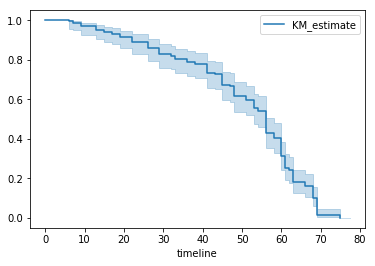

In [51]:

# print(kmf.survival_function_)
# print(kmf.median_)
kmf.plot()

# Multiple group

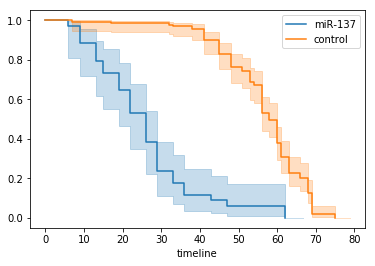

In [116]:
mir = df[df.group.str.contains('miR-137')]
ctrl = df[df.group.str.contains('control')]

kmf.fit(mir[['T']], mir[['E']], label='miR-137')
ax = kmf.plot()

kmf_funnc = kmf.survival_function_

kmf.fit(ctrl[['T']], ctrl[['E']], label='control')
kmf.plot(ax=ax)


# NelsonAalenFitter

culmulative hazard

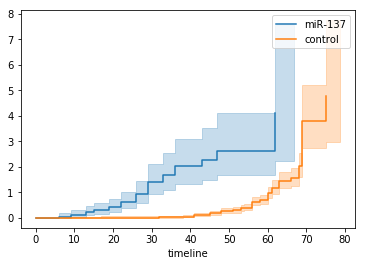

In [54]:
from lifelines import NelsonAalenFitter
naf = NelsonAalenFitter()

naf.fit(mir[['T']], mir[['E']], label='miR-137')
ax = naf.plot()

naf.fit(ctrl[['T']], ctrl[['E']], label='control')
# print(naf.cumulative_hazard_)
naf.plot(ax=ax)

# Baseline: Logistic regression, MLP

In [189]:
dummy = []
for idx, row in mir.iterrows():
    row_ = row.values.tolist()
    pads = [[float(t), 0, row_[2]] for t in range(int(row_[0]))]
    dummy.extend(pads)
    
dummy = pd.DataFrame(dummy)
idx = np.random.choice(dummy.index, len(mir))
dummy = dummy[dummy.index.isin(idx)]
dummy.columns = mir.columns

mir_lr = pd.concat([mir, dummy], ignore_index=True)
# mir_lr = pd.concat([mir_lr, mir_lr, mir_lr], ignore_index=True) # longer!

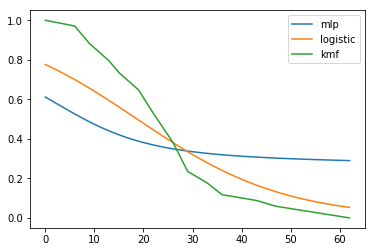

In [190]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

lr = LogisticRegression()
mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='logistic')

lr.fit(mir_lr[['T']], mir_lr['E'])
mlp.fit(mir_lr[['T']], mir_lr['E'])

xmax = mir[['T']].max()
xmin = 0
xplot = np.linspace(xmin, xmax, 50).reshape([-1,1])
lr_plot = list(zip(*lr.predict_proba(xplot)))[0]
mlp_plot = list(zip(*mlp.predict_proba(xplot)))[0]


fig, ax = plt.subplots()
plt.plot(xplot, mlp_plot, label='mlp')
plt.plot(xplot, lr_plot, label='logistic')
plt.plot(kmf_funnc, label='kmf')

plt.legend()

# Some utils

In [191]:
from lifelines.utils import datetimes_to_durations

df = pd.DataFrame({
    'start': ['1970-01-01','1970-01-02','1970-01-02'],
    'end': ['2016-01-01','2017-01-02','1970-01-03']
})

T, E = datetimes_to_durations(df.start, df.end)
print(T)
print(E)

[  1.68010000e+04   1.71670000e+04   1.00000000e+00]
[ True  True  True]


In [44]:
from lifelines.utils import survival_table_from_events

table = survival_table_from_events(T, E)

table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,3,3
1.0,1,1,0,0,3
16801.0,1,1,0,0,2
17167.0,1,1,0,0,1


# CoxPHFitter

Survivial Regression

In [45]:
from lifelines.datasets import load_regression_dataset
regression_dataset = load_regression_dataset()

regression_dataset.head()

,var1,var2,var3,T,E
0,0.595170,1.143472,1.571079,14.785479,1
1,0.209325,0.184677,0.356980,7.336734,1
2,0.693919,0.071893,0.557960,5.271527,1
3,0.443804,1.364646,0.374221,11.684168,1
4,1.613324,0.125566,1.921325,7.637764,1


n=200, number of events=189

       coef  exp(coef)  se(coef)      z      p  lower 0.95  upper 0.95    
var1 0.2213     1.2477    0.0743 2.9795 0.0029      0.0757      0.3669  **
var2 0.0508     1.0521    0.0829 0.6126 0.5401     -0.1117      0.2133    
var3 0.2186     1.2443    0.0758 2.8839 0.0039      0.0700      0.3672  **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.580


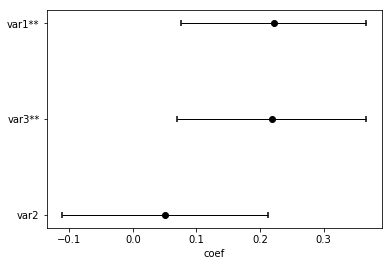

In [62]:
from lifelines import CoxPHFitter

# Using Cox Proportional Hazards model
cph = CoxPHFitter()
cph.fit(regression_dataset, 'T', event_col='E')
cph.print_summary()

cph.plot()

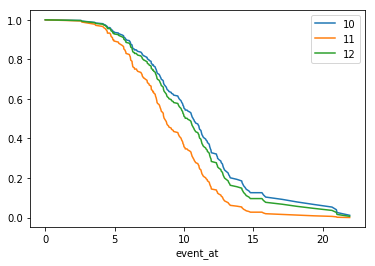

In [194]:
X = regression_dataset.drop(['E', 'T'], axis=1)

cph.predict_survival_function(X.iloc[10:13]).plot()

 [-----------------100%-----------------] 189 of 189 complete in 0.2 sec


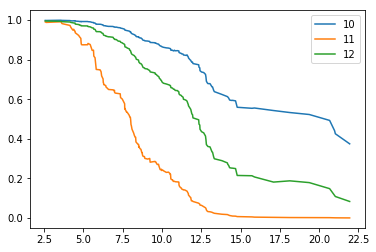

In [200]:
# Using Aalen's Additive model
from lifelines import AalenAdditiveFitter
aaf = AalenAdditiveFitter(fit_intercept=False)
aaf.fit(regression_dataset, 'T', event_col='E')

X = regression_dataset.drop(['E', 'T'], axis=1)
aaf.predict_survival_function(X.iloc[10:13]).plot()

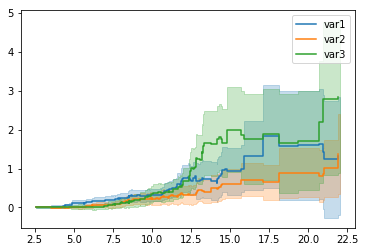

In [65]:
aaf.plot()